In [1]:
import numpy as np
from astropy.modeling.blackbody import blackbody_lambda
from astropy import units as u
from astropy import constants as const
import simcado as sim
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sim.__version__

'0.4dev-METIS'

### Number of photons generated in M1 space

##### Compute number of photons in M1 space from basic considerations

In [3]:
area_ELT=np.pi*((38*u.m)**2-(11.1*u.m)**2)/4
eff_wave=11.5*u.micron ## N2 filter
bandwidth=(13.04-10.21)*u.micron ## N2 filter
solid_angle=(0.01078*u.arcsecond)**2
e_phot=const.h*const.c/eff_wave
r=blackbody_lambda(eff_wave,282*u.K)
emissivity_M1 = 0.23 # total emissivity of ELT according to ESO ICD
n_ph_per_s=emissivity_M1*r*bandwidth*area_ELT*solid_angle/e_phot
print("Expected: The number of photons emitted from M1 per second per pixel is {0:.2E}".format(n_ph_per_s.decompose().value))

Expected: The number of photons emitted from M1 per second per pixel is 7.57E+08


##### Now compare this number to what Simcado computes

In [4]:
from simcado.spectral import BlackbodyCurve as sim_bb

In [5]:
## the wave array needs to have > 2 elements, otherwise edge effects 
## make the number of photons a factor of 2 too large
wave_array=np.arange(10.21,13.04,0.01)

In [6]:
em=sim_bb(wave_array,282-273,pix_res=0.01078,area=area_ELT.value)
em_n_ph=emissivity_M1*em.photons_in_range()
print("SimCADO: The number of photons emitted from M1 per second per pixel is \
{0:.2E}".format(em_n_ph))

SimCADO: The number of photons emitted from M1 per second per pixel is 7.54E+08


The two numbers are identical. Yay!

##### Now compare this number to what Roy computed

In [7]:
# to compare to Roy's number the number above needs to be corrected for 
#    - contribution by atmosphere (10%)
#    - contribution by the entrance window (10%)
#    - transmission of N2 filter (36%/77%); divided by transmission of telescope (which is included in the emissivity)
# We thus arrive at
n_ph_per_s_det = n_ph_per_s*1.1*1.1*0.36/0.77
print("Expected: The number of photons arriving at the detector per second per pixel is {0:.2E}".format(n_ph_per_s_det.decompose().value))

Expected: The number of photons arriving at the detector per second per pixel is 4.28E+08


This number can be compared with Roy's fluxes document (v0.8, Table 4, N2 filter, median conditions) where 5.5e8 photons are given. This means: we miss a factor 1.3 in background photons

### Number of photons on the detector

In [8]:
cmd = sim.UserCommands("metis_image_NQ.config")
cmd["OBS_EXPTIME"]=0.01
cmd["ATMO_USE_ATMO_BG"] = "no"
cmd["SCOPE_USE_MIRROR_BG"] = "yes"
cmd["SIM_VERBOSE"]="no"

In [10]:
opt = sim.OpticalTrain(cmd)

In [13]:
fpa = sim.Detector(cmd, small_fov=False)

In [14]:
## generate a source with N=0.8 mag
lam, spec = sim.source.flat_spectrum(0.8, "../data/TC_filter_N2.dat")
#src = sim.Source(lam=lam, spectra=np.array([spec]), 
#                 ref=[0,0], x=[0,0.07], y=[0,0.07])
src = sim.Source(lam=lam, spectra=np.array([spec]), 
                 ref=[0], x=[0], y=[0])

In [15]:
opt._gen_thermal_emission()

(790084025.13811052, BlackbodyCurve 
 [ 0.  0.  0. ... 0.  0.  0.])

#### Directly comparing produced and final number of photons in Simcado

In [21]:
opt._gen_thermal_emission()[1].photons_in_range()#
# this is more or less consistent with sim_bb (but 5% MORE)

791302476.519328

In [22]:
opt._gen_all_tc()
opt.n_ph_mirror
# this is the number of background photons we get in the final produced image

220048350.24866682

#### Generate the transmission curves ourselves

In [23]:
TC_ELT=sim.spectral.TransmissionCurve("../data/TC_mirror_total_emissivity.dat")

In [24]:
TC_window=sim.spectral.TransmissionCurve("../data/TC_window_METIS.dat")

In [25]:
TC_dichroic_CFO=sim.spectral.TransmissionCurve("../data/TC_dichroic_CFO.dat")

In [26]:
# TC pupil is 1

In [27]:
TC_CFO_mirrors=sim.spectral.TransmissionCurve("../data/TC_mirror_aluminium.dat")

In [28]:
TC_CFO=TC_CFO_mirrors**19

In [29]:
TC_dichroic_IMG=sim.spectral.TransmissionCurve("../data/TC_dichroic_IMG.dat")

In [30]:
TC_N2=sim.spectral.TransmissionCurve("../data/TC_filter_N2.dat")

In [31]:
QE_AQUARIUS=sim.spectral.TransmissionCurve("../data/TC_detector_METIS_NQ.dat")

In [32]:
TC_total=TC_ELT*TC_window*TC_dichroic_CFO*TC_CFO*TC_dichroic_IMG*TC_N2*QE_AQUARIUS

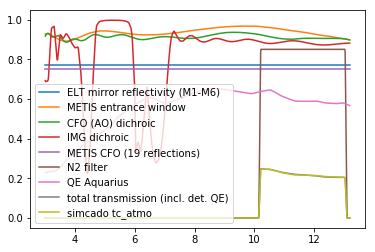

In [33]:
plt.plot(opt.tc_mirror.lam,TC_ELT,label="ELT mirror reflectivity (M1-M6)")
plt.plot(opt.tc_mirror.lam,TC_window,label="METIS entrance window")
plt.plot(opt.tc_mirror.lam,TC_dichroic_CFO,label="CFO (AO) dichroic")
plt.plot(opt.tc_mirror.lam,TC_dichroic_IMG,label="IMG dichroic")
plt.plot(opt.tc_mirror.lam,TC_CFO,label="METIS CFO (19 reflections)")
plt.plot(opt.tc_mirror.lam,TC_N2,label="N2 filter")
plt.plot(opt.tc_mirror.lam,QE_AQUARIUS,label="QE Aquarius")
plt.plot(opt.tc_mirror.lam,TC_total,label="total transmission (incl. det. QE)")
#plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="simcado tc_mirror")
plt.plot(opt.tc_mirror.lam,opt.tc_atmo,label="simcado tc_atmo")
plt.legend(loc=3)
plt.savefig("METIS_transmission_curves.png")

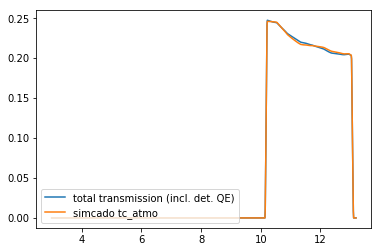

In [34]:
plt.plot(opt.tc_mirror.lam,TC_total,label="total transmission (incl. det. QE)")
#plt.plot(opt.tc_mirror.lam,opt.tc_mirror,label="simcado tc_mirror")
plt.plot(opt.tc_mirror.lam,opt.tc_atmo,label="simcado tc_atmo")
plt.legend(loc=3)

In [35]:
# reading off from the transmission curve plot
TC_total_N2 = 0.22
## for comparison: Roy's value
# transmission from M1 to just before the detector
transmission_Roy_nodet=0.356
transmission_Roy_withdet=transmission_Roy_nodet*0.6
transmission_Roy_withdet

0.21359999999999998

#### Compute number of background photons in SimCADO simulated image

In [39]:
src.apply_optical_train(opt, fpa)
hdu = fpa.read_out(OBS_EXPTIME=1)

Generating image for chip 1
Reading out chip 1 using superfast
2.30748496609e+13 220048350.249 455077860.68 220048350.249
2.30749e+14 2.19973e+08 4.55074e+08 2.20049e+08


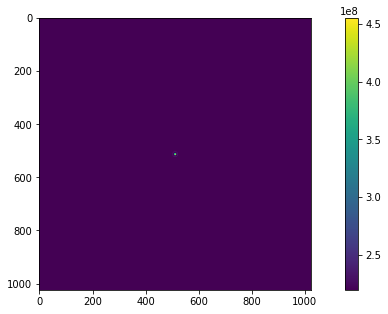

In [40]:
plt.figure(figsize=(12,5))
#plt.imshow(hdu[0].data[800:1200,500:1500], norm=LogNorm(), interpolation="none")
plt.imshow(hdu[0].data, interpolation="none")
plt.colorbar()

In [41]:
bgphotons_per_pix=np.median(hdu[0].data)
print("The number of bg photons per second per pix is {0:.2E}".format(bgphotons_per_pix))

The number of bg photons per second per pix is 2.20E+08


This number can be compared with 5.5e8 from Roy's doc (N2/median, Table 4, version 0.8) * detector_QE = 3.3e8

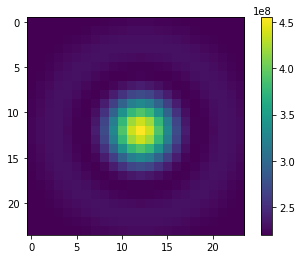

In [42]:
# Star photon counts
plt.imshow(hdu[0].data[500:524,500:524])
plt.colorbar()

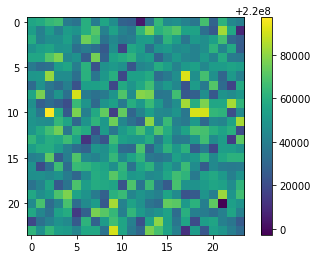

In [43]:
plt.imshow(hdu[0].data[400:424,400:424])
plt.colorbar()

In [44]:
source = np.sum(hdu[0].data[500:524,500:524])
bg = np.sum(hdu[0].data[400:424,400:424])
source_bg = source - bg
print("Number of source photons (per s): {0:.2E}, Number of bg photons (per s): {1:.2E}, bg-subtracted source photons (per s): {2:.2E}".format(source, bg, source_bg))

Number of source photons (per s): 1.37E+11, Number of bg photons (per s): 1.27E+11, bg-subtracted source photons (per s): 9.97E+09


### Compare to the number of photons to expect

In [85]:
# check sim.source.photons_to_mag

In [45]:
# source of 0.8 mag corresponds to 19 Jy
from astropy import units as u
from astropy import constants as c
F = 19 * u.Jy
lam1=10.12*u.micron
lam2=13.13*u.micron
nu1 = c.c/lam1
nu2 = c.c/lam2
bandwidth_nu = - (nu2-nu1)

In [46]:
bandwidth_nu.to("Hz")

<Quantity 6791128684122.596 Hz>

In [47]:
e_ph = c.h*(0.5*(nu2+nu1))
N_ph = (F * 1*u.s * area_ELT * bandwidth_nu / e_ph).decompose()

In [48]:
# before any transmission losses
N_ph

<Quantity 77018448594.75706>

In [49]:
#after transmission losses and QE
total_transmission = 0.36 # N2
detector_QE = 0.6
N_ph*total_transmission*detector_QE

<Quantity 16635984896.467524>

This number is a factor ~1.7 higher than the photon (electron) count rate in the Simcado FITS file

In [50]:
sim.source.mag_to_photons("../data/TC_filter_N2.dat",0.8)*area_ELT/(u.m*u.m)

<Quantity 44815412564.54715>

N_ph * transmission of N2 filter = 6.5e10 ph/s, but here we get 4.5e10 ph/s --> Something in the conversion from mag to photons seems to be wrong

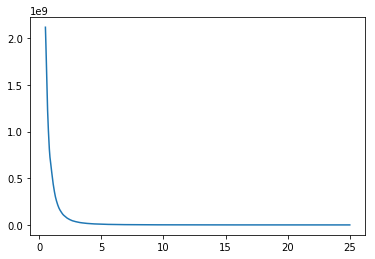

In [153]:
### compute number of photons directly from Sirius curve
from astropy.io import ascii
sirius=ascii.read("../data/sirius_downsampled.txt")
plt.plot(sirius["wlen"],sirius["nphot"])

In [157]:
n_phot_sirius=np.sum(sirius["nphot"][(sirius["wlen"]>lam1.value) & (sirius["wlen"]<lam2.value)])*area_ELT/(u.m*u.m)

In [158]:
flux_ratio_sirius_star_in_file = 10**(-(0.8+1.39)/2.5)
flux_ratio_sirius_star_in_file

0.1330454417978091

In [161]:
n_phot_star_in_file = n_phot_sirius * flux_ratio_sirius_star_in_file
n_phot_star_in_file

<Quantity 54964637659.01207>

Consistent with the measured bg-subtracted source counts in Simcado (after transmission + QE losses)

Result from session on 18 June
 * The background flux is still a factor 1.7 too low (but the transmission of M1 is not the problem)
 * The number of photons that we expect from a 0.8 mag star is 1.8 times higher than the actual photon count rate on the simulated detector
 * Next: look at mag/photon conversion and/or input reference spectrum (Sirius)

##### Compute number of photons on detector (with detector QE) from basic calculation

In [68]:
area_ELT=np.pi*((37.3*u.m)**2-(11.1*u.m)**2)/4
eff_wave=11.5*u.micron ## N2 filter
bandwidth=(13.10-10.15)*u.micron ## N2 filter
solid_angle=(0.01078*u.arcsecond)**2
e_phot=const.h*const.c/eff_wave
r=blackbody_lambda(eff_wave,282*u.K)
emissivity_ELT = 0.23 # ESO ICD for ELT
n_ph_per_s=emissivity_ELT*r*bandwidth*area_ELT*solid_angle/e_phot*TC_total_N2
print("Expected: The number of photons before detector (but with det. QE) per second per pixel is {0:.2E}".format(n_ph_per_s.decompose().value))

Expected: The number of photons before detector (but with det. QE) per second per pixel is 1.74E+08
